# Imports

In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Download Data

In [2]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [3]:
test_name = 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy'
test_name = "TH_20220721_R_F0_O_Switchback_AA_Test_Trang"
start_date = "2022-07-20"
end_date = "2022-08-18"

In [4]:
query = f"""
SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,
        a.order_placed_at,

        -- Location of order
        a.region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.order_id,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        --KPIs that we want to measure
        orders.rider.timings.actual_delivery_time/60 delivery_time,
        orders.rider.timings.order_delay/60 order_delay,
        orders.rider.timings.bag_time/60 bag_time,
        ARRAY(SELECT d.dropoff_distance_manhattan FROM UNNEST(orders.rider.deliveries) AS d)[OFFSET(0)] distance,
        
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.cl.orders_v2` orders ON a.entity_id = orders.entity_id AND a.platform_order_code = orders.global_order_id
    WHERE TRUE
        AND a.created_date BETWEEN DATE("{start_date}") AND DATE("{end_date}")
        AND b.test_name = "{test_name}" -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the
"""

In [5]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client

data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/158911 [00:00<?, ?rows/s]

In [6]:
KPI = "order_delay"

In [7]:
data = data[data['delivery_time']<120]
data = data[data['distance']<100000]
data = data[data[KPI].notnull()]

<AxesSubplot:xlabel='order_delay', ylabel='Density'>

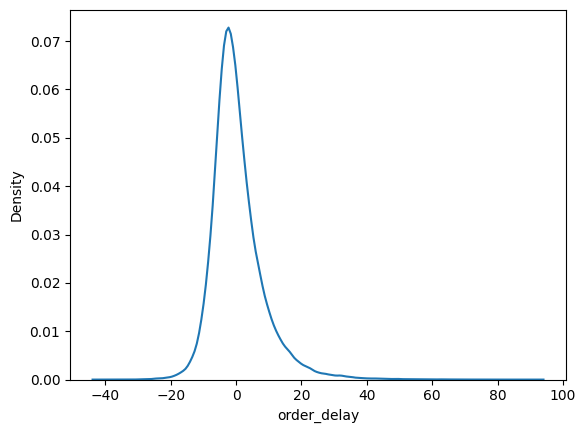

In [8]:
sns.kdeplot(data[KPI])

In [9]:
data[KPI].mean()

0.439899628038535

In [19]:
def randomize_time_unit_assignment(data):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [20]:
window_sizes = [str(i)+"H" for i in range(1,12)]+["1D", "2D", "3D"]
# window_sizes = ["1D", "2D", "3D"]
window_sizes

['1H',
 '2H',
 '3H',
 '4H',
 '5H',
 '6H',
 '7H',
 '8H',
 '9H',
 '10H',
 '11H',
 '1D',
 '2D',
 '3D']

# Confidence Intervals

In [21]:
def naive_order_level_CI(data, KPI):
    """Calculates confidence intervals on order level."""
    std_A = data[data['group']=='A'][KPI].std()
    std_err_A = std_A/np.sqrt(len(data[data['group']=='A'][KPI]))
    std_B = data[data['group']=='B'][KPI].std()
    std_err_B = std_B/np.sqrt(len(data[data['group']=='B'][KPI]))
    mean_diff = data[data['group']=='A'][KPI].mean()-data[data['group']=='A'][KPI].mean()
    return np.sqrt(std_err_A**2+std_err_B**2), mean_diff

In [22]:
def time_unit_CI(data, KPI):
    """Calculate confidence intervals for time unit level."""
    A = data[data['group']=='A'].groupby('time_unit')[KPI].mean()
    N_A = len(A)
    # the ttest usees a corrected estimate of the std deviation because of small sample size
    factor = np.sqrt(N_A/(N_A-1))
    std_err_A = factor*A.std()/np.sqrt(N_A)
    B = data[data['group']=='B'].groupby('time_unit')[KPI].mean()
    N_B = len(B)
    factor = np.sqrt(N_B/(N_B-1))
    std_err_B = factor*B.std()/np.sqrt(N_B)
    mean_diff = A.mean()-B.mean()
    return np.sqrt(std_err_A**2+std_err_B**2), mean_diff

In [23]:
def adjusted_p_value_CI(data, KPI, n_iterations=100):
    """Calculates the confidence intervals for the adusted p-value method."""
    measured_effects = []
    for i in range(n_iterations):
        randomize_time_unit_assignment(data)
        measured_effect = data[data['group']=='A'][KPI].mean()-data[data['group']=='B'][KPI].mean()
        measured_effects.append(measured_effect)
    std = np.std(measured_effects)
    return std, 0

In [24]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

In [25]:
def get_CIs_for_different_window_sizes(CI_function, KPI, window_sizes):
    """Calculates confidence intervals for a certain method for different specified window_sizes."""
    CIs = []
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['order_placed_at'].dt.floor(window_size)
        randomize_time_unit_assignment(data)
        CI, _ = CI_function(data, KPI)
        CIs.append(CI)
    return pd.Series(CIs, index=window_sizes, name=CI_function.__name__)

In [26]:
results = pd.DataFrame()
for CI_function in [time_unit_CI, adjusted_p_value_CI, CRSE_CI]:
    CIs = get_CIs_for_different_window_sizes(CI_function, KPI, window_sizes)
    results[CIs.name] = CIs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:13<00:00,  1.00it/s]


Text(0.5, 1.0, '95% CI for different window sizes')

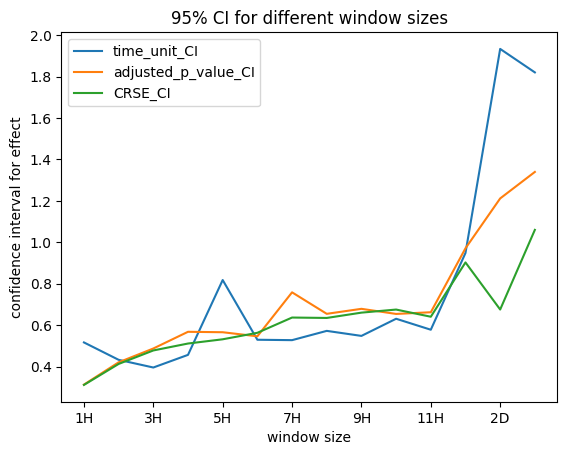

In [27]:
# for 95% CI multiply by 2
(results*2).plot()
plt.ylabel("confidence interval for effect")
plt.xlabel("window size")
plt.title("95% CI for different window sizes")